In [42]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
import io
%config Completer.use_jedi = False

In [45]:
# bluezone , redzone or errornious data may have cordinates as 0
def filter_person_kills(death_df):
    death_df=death_df.dropna()
    death_df = death_df[(death_df['victim_position_x'] != 0) | (death_df['victim_position_y'] != 0)]
    death_df = death_df[(death_df['killer_position_x'] != 0) | (death_df['killer_position_y'] != 0)]
    return death_df


def adjust_position(df,m="e"):
    scaler=4096/800000
    if m!="e":
        scaler/=1.25
    columns=["victim_position_x","victim_position_y","killer_position_x","killer_position_y"]
    for col in columns:
        df[col]=df[col]*scaler
    return df

In [43]:
# total data is about 18.89Gb , so lets just analyse a part of it
def load_multiple_csv(input_dir, sampling=0.002):
    input_dir = Path(input_dir)
    dfs = []
    for input_path in tqdm(input_dir.glob('*.csv')):
        df = pd.read_csv(input_path)
        df = df.sample(int(len(df)*sampling))
        dfs.append(df)
    
    df = pd.concat(dfs)
    del dfs
    return df
data=load_multiple_csv('../input/pubg-match-deaths/deaths')

|          | 0/? [00:00<?, ?it/s]

In [47]:
reds_color = np.zeros((100, 4))
reds_color[:, 0] = np.linspace(0, 1, 100)
reds_color[:, 3] = np.linspace(0.4, 1, 100)
reds_color[:10] = 0
alpha_reds_cmap = mcolors.LinearSegmentedColormap.from_list('alpha_reds', colors=reds_color, N=1024, gamma=1)

greens_color = np.zeros((100, 4))
greens_color[:, 1] = np.linspace(0, 1, 100)
greens_color[:, 3] = np.linspace(0.4, 1, 100)
greens_color[:10] = 0
alpha_greens_cmap = mcolors.LinearSegmentedColormap.from_list('alpha_greens', colors=greens_color, N=1024, gamma=1)
def generate_heatmap(df,
                     img,
                     n_grid=100,
                     bw=200,
                     kernel='epanechnikov',
                     cmap=plt.cm.Reds,
                     alpha=None,
                     ax=None,
                    ):
    x_mesh = np.linspace(0, 4096, n_grid)
    y_mesh = np.linspace(0, 4096, n_grid)
    X, Y = np.meshgrid(x_mesh, y_mesh)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(df.to_numpy())
    log_density = kde.score_samples(xy)
    log_density = log_density.reshape((n_grid, n_grid))
    density = np.exp(log_density)

    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 16))

    plt.gca().invert_yaxis()
    ax.contourf(X, Y, density, alpha=alpha, cmap=cmap)
    ax.imshow(img)
    return fig, ax

In [116]:
erangel_img = Image.open('../input/pubg-match-deaths/erangel.jpg')

In [92]:
death_data=adjust_position(filter_person_kills(data),m="e")
position_data=death_data[["map","killer_placement","victim_placement","victim_position_x","victim_position_y","killer_position_x","killer_position_y"]]
position_data=position_data.reset_index()
position_data=position_data.drop(columns=["index"])

In [117]:
erangel_death_df = position_data[position_data['map'] == 'ERANGEL']
position_df["victim_position_x"].append(erangel_death_df["killer_position_x"])
position_df["victim_position_y"].append(erangel_death_df["killer_position_y"])
# fig, ax = generate_heatmap(erangel_death_df[["victim_position_x","victim_position_y"]], erangel_img, bw=200, cmap=alpha_reds_cmap)

0         2449.596416
1         2188.545536
2         2035.709440
3         3396.834816
4         1467.767808
             ...     
114488    2596.265574
114489    1370.991821
114490    1274.031309
114492    1925.051187
114493    1698.242560
Length: 187964, dtype: float64

In [118]:
def euclidian_distance(a, b):
    return np.sqrt(((a - b)**2).sum(axis=1))
erangel_death_df=position_data[position_data['map']=='ERANGEL']
erangel_death_df['distance']=euclidian_distance(erangel_death_df[['victim_position_x','victim_position_y']].to_numpy(),erangel_death_df[['killer_position_x','killer_position_y']].to_numpy())
sniper_death_df=erangel_death_df[erangel_death_df['distance']>erangel_death_df['distance'].quantile(0.85)]
# fig,ax=generate_heatmap(sniper_death_df[['killer_position_x','killer_position_y']],erangel_img,bw=70,cmap=alpha_reds_cmap)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [119]:
erangel_death_df = position_data[position_data['map'] == 'ERANGEL']
landing_df = erangel_death_df[erangel_death_df['victim_placement'] > 50][['victim_position_x', 'victim_position_y']]
# fig,ax=generate_heatmap(landing_df, erangel_img, bw=180, cmap=alpha_reds_cmap)

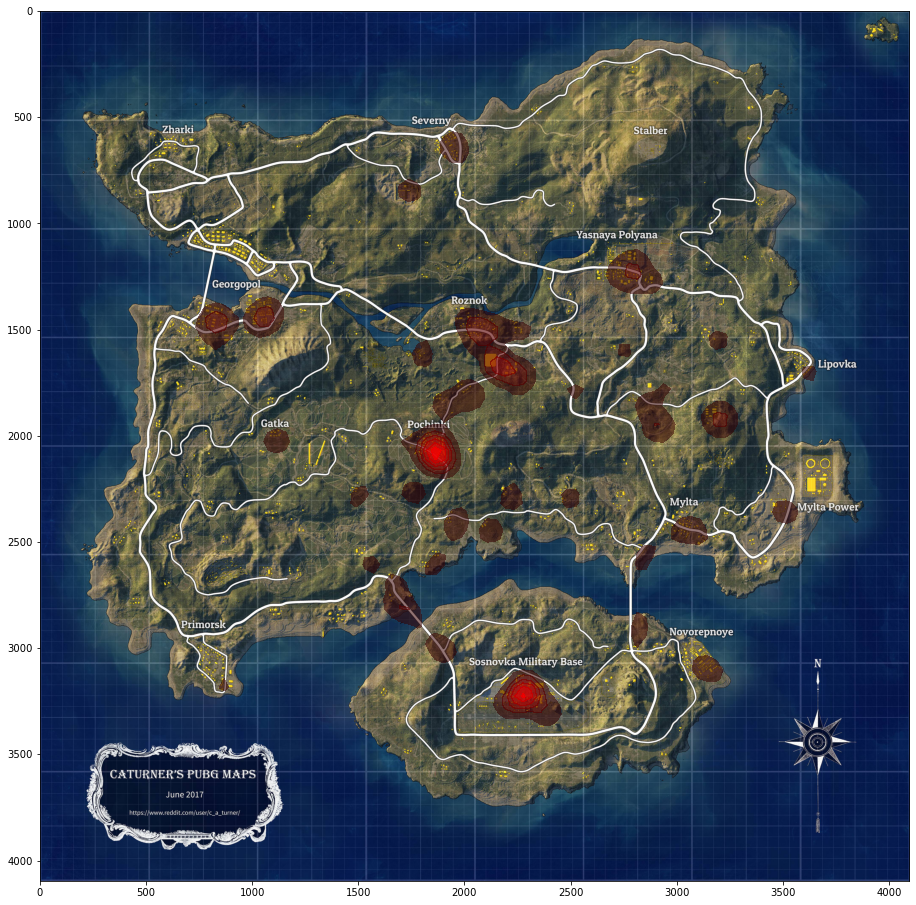

In [94]:
erangel_death_df = position_data[position_data['map'] == 'ERANGEL']
ending_df = erangel_death_df[erangel_death_df['killer_placement'] < 5][['killer_position_x', 'killer_position_y']]
# fig,ax=generate_heatmap(ending_df, erangel_img, bw=90, cmap=alpha_reds_cmap)

In [115]:
miramar_img=Image.open('../input/pubg-match-deaths/miramar.jpg')
